# Calibrating Derp with Air Measurement

Here we will construct a procedure for calibrating Derp by measuring air. The air measurement is done because it is the closest thing to a "well-known" Mueller matrix that is physically realizable (and inexpensive). There are a couple ways to do so that we are interested in comparing, so we also illustrate those here.

The results int his notebook will be done with the Thorlabs laser because the SuperK has been unstable. 


We begin by importing the necessary modules and initializing the Camera.

In [1]:
import numpy as np
import derpy
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from scipy.optimize import minimize

from katsu.mueller import(
    linear_retarder,
    linear_polarizer
)

In [2]:
cam = derpy.CRED2(set_temperature=-40, fps=10, tint=90, temp_tolerance=0.5) # TODO: add units to docstring (also add docstring)

Updating...
Sensor Temperature: -40.04C
Motherboard Temperature: 37.75C
Frontend Temperature: 40.0C
Powerboard Temperature: 43.0C
Peltier Temperature: 14.05C
Heatsink Temperature: 36.58C
***********************
Sensor Temperature: -40.04C
Motherboard Temperature: 37.75C
Frontend Temperature: 40.0C
Powerboard Temperature: 43.0C
Peltier Temperature: 14.05C
Heatsink Temperature: 36.58C
***********************
Final Sensor Temperature -40.04C
Prior camera tint: 0.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.09999621

In [3]:
cam.tint = 1

Prior camera tint: 0.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.0900010430.

The cooldown process can be viewed by plotting the temperature_change attribute

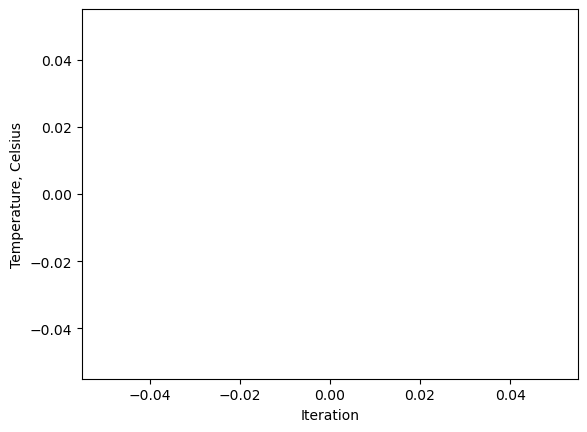

In [4]:
plt.figure()
plt.plot(cam.temperature_change, marker='o')
plt.ylabel('Temperature, Celsius')
plt.xlabel('Iteration')
plt.show()

In [5]:
fstg = derpy.FocusStage()

c:\Users\EPL User\.conda\envs\pylablib_env\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model LTS150C; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [8]:
# Are we getting an image
dark = cam.take_median_image(10)

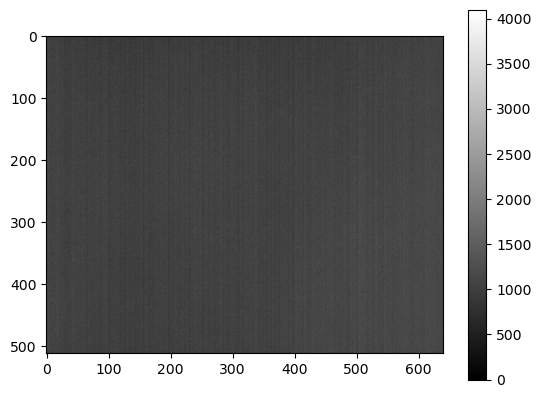

In [9]:
plt.imshow(dark, cmap='gray', vmax=2**12)
plt.colorbar()

In [25]:
fstg.step(3e6)

In [35]:
# now a bright
bright = cam.take_median_image(10)

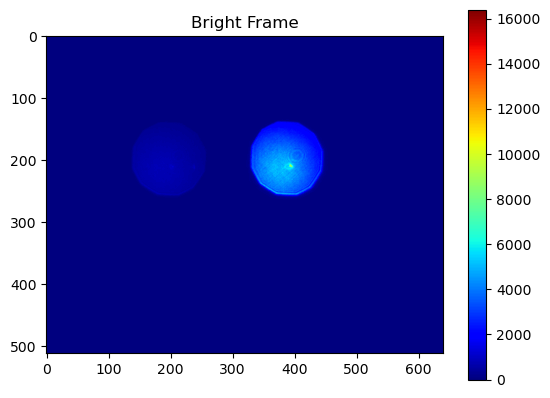

In [36]:
plt.title("Bright Frame")
plt.imshow(bright- dark, cmap='jet', vmax=2**14, vmin=0)
plt.colorbar()

Determine a window to use on the data. The data inside these pupils should be relatively uniform

C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\3340890271.py:29: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r')
C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\3340890271.py:29: RuntimeWarning: invalid value encountered in divide
  plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r')


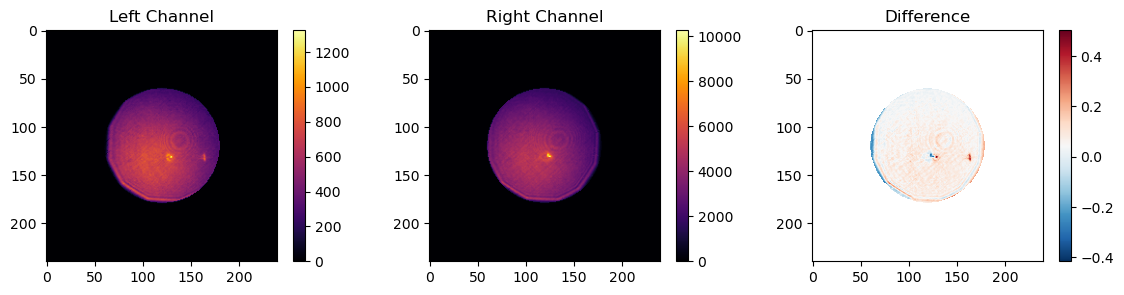

In [37]:
bright = cam.take_many_images(10)
bright_avg = np.median(bright, axis=0) - dark
bright_avg[bright_avg < 0] = 0
cxr, cyr = 200, 390
cxl, cyl = 200, 200 - 5
cut = 120

x = np.linspace(-1,1,2*cut)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 0.5] = 1

left_channel = bright_avg[cxl-cut:cxl+cut,cyl-cut:cyl+cut]
right_channel = bright_avg[cxr-cut:cxr+cut,cyr-cut:cyr+cut]

plt.style.use("default")
plt.figure(figsize=[14,3])
plt.subplot(131)
plt.title("Left Channel")
plt.imshow(mask * left_channel, cmap='inferno')
plt.colorbar()
plt.subplot(132)
plt.title("Right Channel")
plt.imshow(mask * right_channel, cmap='inferno')
plt.colorbar()
plt.subplot(133)
plt.title("Difference")
plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r')
plt.colorbar()
plt.show()

Next we initialize the rotation stages

In [38]:
psg_stg = derpy.PSGRotationStage()
psa_stg = derpy.PSARotationStage()

The following will illustrate the construction of an object that is capable of tracking the state of Derp, which is critical to update throughout the experiment.

In [39]:
class Experiment:

    def __init__(self, cam, psg, psa,
                 psg_pol_angle=0, psg_wvp_angle=0, psg_wvp_ret=np.pi/2,
                 psa_pol_angle=0, psa_wvp_angle=0, psa_wvp_ret=np.pi/2,
                 dark=None, cxr=200, cyr=390, cxl=200, cyl=195, cut=120):
        
        # initialize the hardware
        self.cam = cam
        self.psg = psg
        self.psa = psa

        # initialize the parameters to calibrate
        self.psg_pol_angle = psg_pol_angle
        self.psg_wvp_ret = psg_wvp_ret
        self.psa_pol_angle = psa_pol_angle
        self.psa_wvp_ret = psa_wvp_ret

        # track the relative waveplate motion
        self.psg_positions_relative = [] # the position history
        self.psg_starting_angle = 0 # where the waveplate started
        self.psa_positions_relative = [] # the position history
        self.psa_starting_angle = 0 # where the waveplate started

        # track the image acquisition history
        self.images = []
        self.mean_power_left = []
        self.mean_power_right = []

        if dark is not None:
            self.dark = dark

        # set up aperture masks
        x = np.linspace(-1, 1, 2*cut)
        x, y = np.meshgrid(x, x)
        r = np.sqrt(x**2 + y**2)
        self.mask = np.zeros_like(r)
        self.mask[r < 0.5] = 1

    def measurement(self, psg_angular_step, psa_angular_step, n_steps, n_imgs=5):

        for i in tqdm(range(n_steps)):

            # move the psg
            self.psg.step(psg_angular_step)
            self.psg_positions_relative.append(psg_angular_step * (i+1))
            sleep(0.1) # beccause of paranoia

            # move the psa
            self.psa.step(psa_angular_step)
            self.psa_positions_relative.append(psa_angular_step * (i+1))
            sleep(0.1)

            # take a measurement
            img = self.cam.take_median_image(n_imgs)
            if hasattr(self, 'dark'):
                img -= self.dark
                img[img < 0] = 1e-10

            # capture the full frame, no sub-pupiling
            self.images.append(img)

            # Get the average power in the sub-pupils
            self.mean_power_left.append(np.mean(img[cxl-cut:cxl+cut, cyl-cut:cyl+cut][self.mask==1]))
            self.mean_power_right.append(np.mean(img[cxr-cut:cxr+cut, cyr-cut:cyr+cut][self.mask==1]))
            
    
    @property
    def psg_wvp_angle(self):
        return self.psg_starting_angle + np.array(self.psg_positions_relative)
    
    @psg_wvp_angle.setter
    def psg_wvp_angle(self, value):
        self.psg_starting_angle = value 
    
    
    @property
    def psa_wvp_angle(self):
        return self.psa_starting_angle + np.array(self.psa_positions_relative)
    
    @psa_wvp_angle.setter
    def psg_wvp_angle(self, value):
        self.psa_starting_angle = value 


def forward_simulate(x, experiment, channel="left"):

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]

    starting_angle_psa_pol = x[3]
    starting_angle_psa_wvp = x[4]
    retardance_psa_wvp = x[5]

    # parse experiment
    psg_angles = np.radians(np.array(experiment.psg_positions_relative))
    psa_angles = np.radians(np.array(experiment.psa_positions_relative))

    shapes = [psa_angles.shape[0]]

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles + starting_angle_psg_wvp, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles + starting_angle_psa_wvp, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    M_total = psa_pol @ psa_wvp @ psg_wvp @ psg_pol
    power_simulated = M_total[..., 0, 0]

    return power_simulated


def forward_calibrate(x, experiment, channel="left"):

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]

    starting_angle_psa_pol = x[3]
    starting_angle_psa_wvp = x[4]
    retardance_psa_wvp = x[5]

    if channel == "left":
        power = experiment.mean_power_left

    elif channel == "right":
        power = experiment.mean_power_right

    else:
        raise ValueError(f"channel '{channel}' must be either 'left' or 'right'")

    power_simulated = forward_simulate(x, experiment, channel=channel)

    # normalize the power
    power_simulated = power_simulated / np.max(power_simulated)
    power = power / np.max(power)

    # compute error to calibrate
    error = np.sum((power - power_simulated)**2)

    return error

We begin by initializing the Experiment object with our various devices

In [40]:
air_test = Experiment(cam, psg_stg, psa_stg, dark=dark)

Next we invoke the measurement method, which takes step sizes for the PSG and PSA, and the number of steps to take. The images and angular steps are saved internally.

In [41]:
ANGULAR_STEP = 3
ANGULAR_RATIO = 2.5
N_MEASUREMENTS = 70

psg_step = ANGULAR_STEP
psa_step = ANGULAR_STEP * ANGULAR_RATIO

print("End angle PSG: ", ANGULAR_STEP * N_MEASUREMENTS)
print("End angle PSA: ", ANGULAR_STEP * ANGULAR_RATIO * N_MEASUREMENTS) 

End angle PSG:  210
End angle PSA:  525.0


In [42]:
air_test.measurement(psg_step, psa_step, N_MEASUREMENTS)

100%|██████████| 70/70 [05:48<00:00,  4.98s/it]


Here's just a plot of the observed power

Text(0.5, 0, 'PSG Angle')

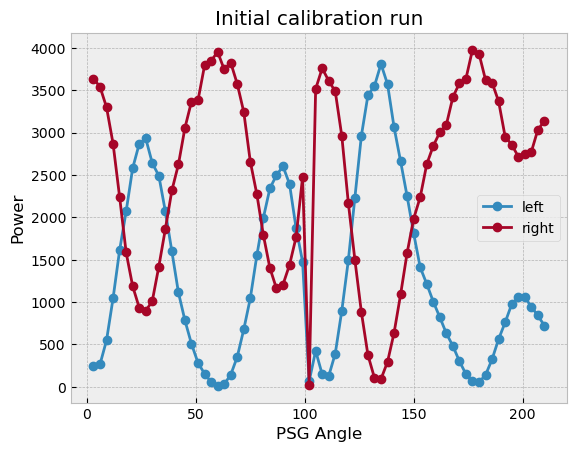

In [43]:
plt.style.use("bmh")
plt.title("Initial calibration run")
plt.plot(air_test.psg_positions_relative, air_test.mean_power_left, label='left', marker='o')
plt.plot(air_test.psg_positions_relative, air_test.mean_power_right, label='right', marker='o')
plt.legend()
plt.ylabel('Power')
plt.xlabel('PSG Angle')

Now we feed the calibration method our guess `x_model` and the experiment.

In [44]:
x_model =[
    0, # starting_angle_psg_pol
    0, # starting_angle_psg_wvp
    np.pi/2, # retardance_psg_wvp
    0, # starting_angle_psa_pol
    0, # starting_angle_psa_wvp
    np.pi/2 # retardance_psa_wvp
]

results = minimize(forward_calibrate, x0=x_model, args=(air_test, 'left'))

In [45]:
print(np.degrees(results.x))

[  23.1269448    14.10683821   89.65872637 -237.88384628  200.64455928
   85.39751925]


After getting the calibrated parameters we can plot how well the fit matches the data

In [46]:
simulated_power = forward_simulate(results.x, air_test, 'left')

Text(0, 0.5, 'Normalized Power')

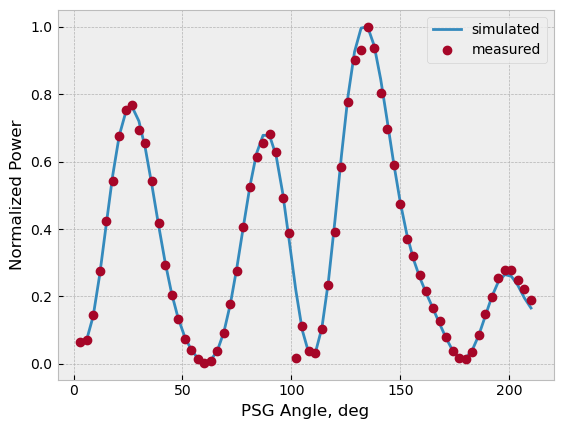

In [47]:
psg_angles = air_test.psg_positions_relative
plt.plot(psg_angles, simulated_power / np.max(simulated_power), label='simulated')
plt.plot(psg_angles, air_test.mean_power_left / np.max(air_test.mean_power_left), label='measured', linestyle="None", marker='o')
plt.legend()
plt.xlabel('PSG Angle, deg')
plt.ylabel('Normalized Power')

That's pretty good! If we look at the calibrated angles we can see that the results aren't too insane. More notably, the retardance values are near 90 degrees, which is what we expect for a quarter waveplate

Now that we have calibrated where our polarimeter has been, we can update the internal angles. This is important for the next step, which is to measure the Mueller matrix of air.

update them with the calibrated values

In [48]:
def calibrate_experiment(x, experiment):

    experiment.psg_pol_angle = x[0]
    experiment.psg_starting_angle = np.degrees(x[1])
    experiment.psg_wvp_ret = x[2]
    experiment.psa_pol_angle = x[3]
    experiment.psa_starting_angle = np.degrees(x[4])
    experiment.psa_wvp_ret = x[5]

    return experiment

In [49]:
air_test_calibrated = calibrate_experiment(results.x, air_test)

In [50]:
air_test_calibrated.psg_wvp_angle

array([208.14455928, 215.64455928, 223.14455928, 230.64455928,
       238.14455928, 245.64455928, 253.14455928, 260.64455928,
       268.14455928, 275.64455928, 283.14455928, 290.64455928,
       298.14455928, 305.64455928, 313.14455928, 320.64455928,
       328.14455928, 335.64455928, 343.14455928, 350.64455928,
       358.14455928, 365.64455928, 373.14455928, 380.64455928,
       388.14455928, 395.64455928, 403.14455928, 410.64455928,
       418.14455928, 425.64455928, 433.14455928, 440.64455928,
       448.14455928, 455.64455928, 463.14455928, 470.64455928,
       478.14455928, 485.64455928, 493.14455928, 500.64455928,
       508.14455928, 515.64455928, 523.14455928, 530.64455928,
       538.14455928, 545.64455928, 553.14455928, 560.64455928,
       568.14455928, 575.64455928, 583.14455928, 590.64455928,
       598.14455928, 605.64455928, 613.14455928, 620.64455928,
       628.14455928, 635.64455928, 643.14455928, 650.64455928,
       658.14455928, 665.64455928, 673.14455928, 680.64

First as a sanity check, we can perform a measurement on the calibrated data.

In [51]:
from katsu.katsu_math import broadcast_kron

def measure_from_experiment(experiment, channel="left"):

    # Where it currently is
    starting_angle_psg_pol = experiment.psg_pol_angle
    starting_angle_psg_wvp = np.radians(experiment.psg_starting_angle)
    retardance_psg_wvp = experiment.psg_wvp_ret

    starting_angle_psa_pol = experiment.psa_pol_angle
    starting_angle_psa_wvp = np.radians(experiment.psa_starting_angle)
    retardance_psa_wvp = experiment.psa_wvp_ret

    # Construct the position arrays
    psg_angles = np.radians(np.array(experiment.psg_positions_relative)) + starting_angle_psg_wvp
    psa_angles = np.radians(np.array(experiment.psa_positions_relative)) + starting_angle_psa_wvp

    if channel == "left":
        images = experiment.images
        power = []
        for img in images:
            cut_power = img[cxl-cut:cxl+cut, cyl-cut:cyl+cut]
            power.append(cut_power)

    elif channel == "right":
        images = experiment.images
        power = []
        for img in images:
            cut_power = img[cxr-cut:cxr+cut, cyr-cut:cyr+cut]
            power.append(cut_power)

        starting_angle_psa_pol += np.pi/2

    # Honest to goodness dual_channel
    else:
        images = experiment.images
        power = []

        for p in range(2):
            for img in images:
                if p == 0:
                    cut_power = img[cxl-cut:cxl+cut, cyl-cut:cyl+cut]
                elif p == 1:
                    cut_power = img[cxr-cut:cxr+cut, cyr-cut:cyr+cut]

                power.append(cut_power)

        # update the psg/psa angles
        psg_angles = np.concatenate([psg_angles, psg_angles])
        psa_angles = np.concatenate([psa_angles, psa_angles])
        print(psa_angles.shape)
    power = np.asarray(power)

    shapes = [*power.shape[-2:], psa_angles.shape[0]]
    shapes_half = [*power.shape[-2:], psa_angles.shape[0]//2]
    power = np.moveaxis(power,0,-1)

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)

    if channel == "right" or channel=="left":
        psa_pol = linear_polarizer(starting_angle_psa_pol)
    else:
        psa_pol_l = linear_polarizer(starting_angle_psa_pol, shape=shapes_half)
        psa_pol_r = linear_polarizer(starting_angle_psa_pol + np.pi/2, shape=shapes_half)
        psa_pol = np.concatenate([psa_pol_l, psa_pol_r], axis=-3)
        print(psa_pol.shape)

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSA = Ma[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)
    power_expand = power[..., np.newaxis]

    # Do the data reduction
    M_meas = Winv @ power_expand
    M_meas = M_meas[..., 0]

    return M_meas.reshape([*M_meas.shape[:-1], 4, 4])


    

In [55]:
M = measure_from_experiment(air_test_calibrated, channel='left')

In [56]:
def plot_square(x,n=4,vmin=None,vmax=None, title=None):
    k = 1
    plt.figure(figsize=[11,8.5])
    if title is not None:
        plt.suptitle(title, fontsize=24)
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            x_mean = np.mean(x[..., i, j][mask==1])
            x_meansub = x[..., i, j] - x_mean
            plt.title(f'{x_mean:.2f}'+r'$\pm$'+f'{np.std(x_meansub[mask==1]):.4f}')
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            plt.colorbar()
            plt.xticks([],[])
            plt.yticks([],[])
            k += 1
    plt.show()

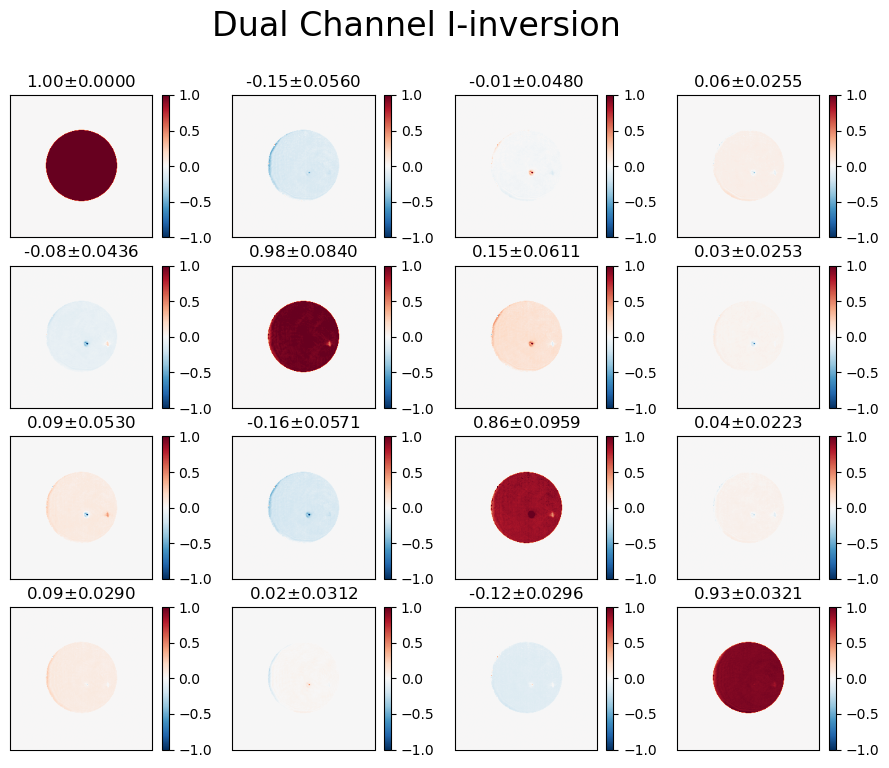

In [57]:
plt.style.use("default")
plot_square(M * mask[..., None, None] / M[..., 0, 0, None, None], title="Dual Channel I-inversion", vmin=-1, vmax=1)

Good to see that the calibration is working. Now we can actually measure the Mueller matrix of air.

In [58]:
air_measure = Experiment(cam, psg_stg, psa_stg, dark=dark)

In [59]:
air_measure.measurement(psg_step, psa_step, N_MEASUREMENTS)

100%|██████████| 70/70 [05:49<00:00,  5.00s/it]


In [60]:
prior_psg_motion = air_test.psg_positions_relative[-1]
prior_psa_motion = air_test.psa_positions_relative[-1]
print(prior_psg_motion)
print(prior_psa_motion)

210
525.0


Text(0.5, 0, 'PSG Angle')

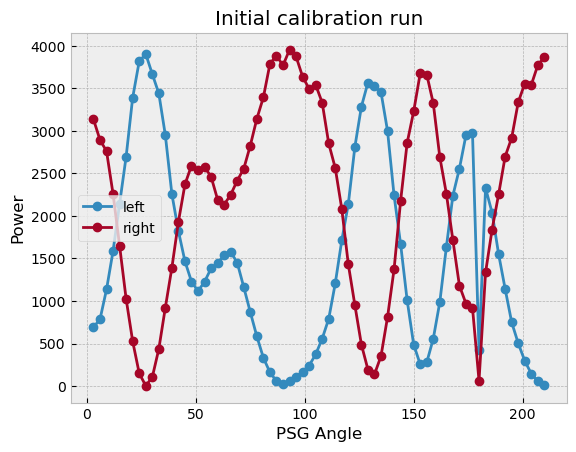

In [61]:
plt.style.use("bmh")
plt.title("Initial calibration run")
plt.plot(air_measure.psg_positions_relative, air_measure.mean_power_left, label='left', marker='o')
plt.plot(air_measure.psg_positions_relative, air_measure.mean_power_right, label='right', marker='o')
plt.legend()
plt.ylabel('Power')
plt.xlabel('PSG Angle')

Now we need to construct the updated calibration parameters. For now, do so manually

In [62]:
air_measure.psg_pol_angle = results.x[0]
air_measure.psg_starting_angle = np.degrees(results.x[1]) + prior_psg_motion
air_measure.psg_wvp_ret = results.x[2]
air_measure.psa_pol_angle = results.x[3]
air_measure.psa_starting_angle = np.degrees(results.x[4]) + prior_psa_motion
air_measure.psa_wvp_ret = results.x[5]

In [63]:
M_measure = measure_from_experiment(air_measure, channel="dual")

(140,)
(240, 240, 140, 4, 4)


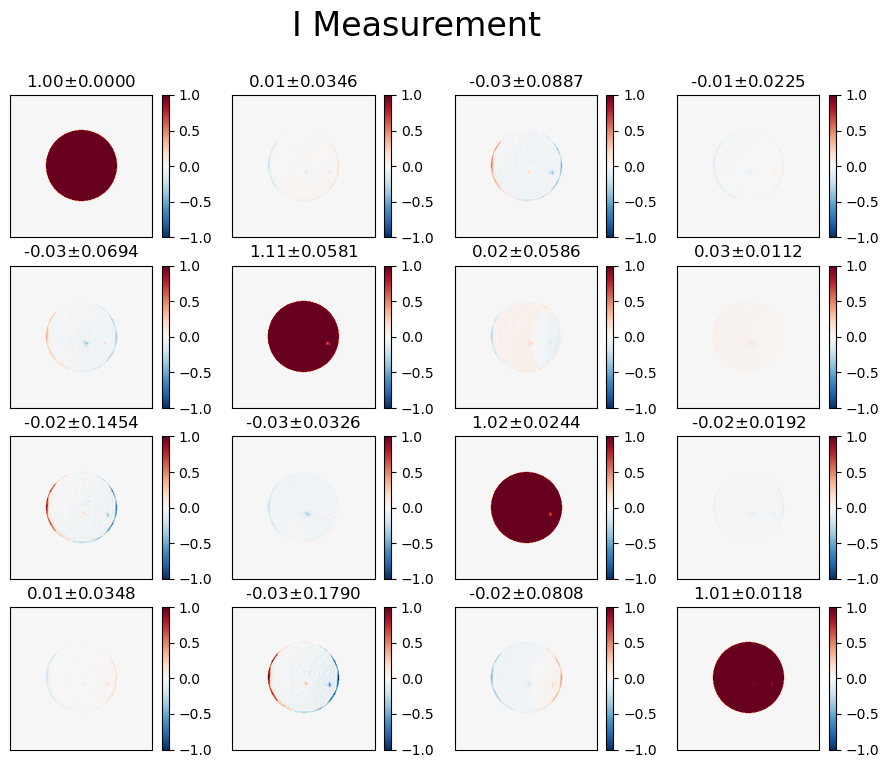

In [64]:
plt.style.use("default")
plot_square(M_measure / M_measure[..., 0, 0, None, None] * mask[..., None, None], vmin=-1, vmax=1, title="I Measurement")

In [103]:
def q_measure_from_experiment(experiment):

    # Where it currently is
    derotate = experiment.psa_pol_angle
    starting_angle_psg_pol = experiment.psg_pol_angle - derotate
    starting_angle_psg_wvp = np.radians(experiment.psg_starting_angle) - derotate
    retardance_psg_wvp = experiment.psg_wvp_ret

    # starting_angle_psa_pol = experiment.psa_pol_angle
    starting_angle_psa_wvp = np.radians(experiment.psa_starting_angle) - derotate
    retardance_psa_wvp = experiment.psa_wvp_ret

    # Construct the position arrays
    psg_angles = np.radians(np.array(experiment.psg_positions_relative)) + starting_angle_psg_wvp
    psa_angles = np.radians(np.array(experiment.psa_positions_relative)) + starting_angle_psa_wvp

    # grab the sub-pupils - TODO: Will need to work on image registration
    images = experiment.images
    power_left = []
    power_right = []
    for img in images:
        cut_power_left = img[cxl-cut:cxl+cut, cyl-cut:cyl+cut]
        cut_power_right = img[cxr-cut:cxr+cut, cyr-cut:cyr+cut]
        power_left.append(cut_power_left)
        power_right.append(cut_power_right)

    power_left = np.asarray(power_left)
    power_right = np.asarray(power_right)

    shapes = [*power_left.shape[-2:], psa_angles.shape[0]]
    power_left = np.moveaxis(power_left, 0, -1)
    power_right = np.moveaxis(power_right, 0, -1)
    Q = (power_left - power_right) / (power_left + power_right)

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    # psa_pol_left = linear_polarizer(starting_angle_psa_pol)
    # psa_pol_right = linear_polarizer(starting_angle_psa_pol + np.pi/2)

    Mg = psg_wvp @ psg_pol
    Ma = psa_wvp
    # Ma_left = psa_pol_left @ psa_wvp
    # Ma_right = psa_pol_right @ psa_wvp

    PSA = Ma[..., 1, :]
    # PSA_Left = Ma_left[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])

    # Wmat_Left = broadcast_kron(PSA_Left[..., np.newaxis], PSG[..., np.newaxis])
    # Wmat_Left = Wmat_Left.reshape([*Wmat_Left.shape[:-2], 16])

    # Winv_Left = np.linalg.pinv(Wmat_Left)
    Winv = np.linalg.pinv(Wmat)
    # power_left_expand = power_left[..., np.newaxis] / (power_left + power_right)[..., np.newaxis]
    Q_expand = Q[..., np.newaxis]
    # power_expand = np.concatenate([power_left_expand, Q_expand], axis=-2)
    # Winv = np.concatenate([Winv_Left, Winv], axis=-1)

    # Do the data reduction
    M_meas = Winv @ Q_expand
    M_meas = M_meas[..., 0]

    return M_meas.reshape([*M_meas.shape[:-1], 4, 4])


# Q data reduction

In [104]:
M_measure = q_measure_from_experiment(air_measure)

C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\238221663.py:33: RuntimeWarning: invalid value encountered in divide
  Q = (power_left - power_right) / (power_left + power_right)


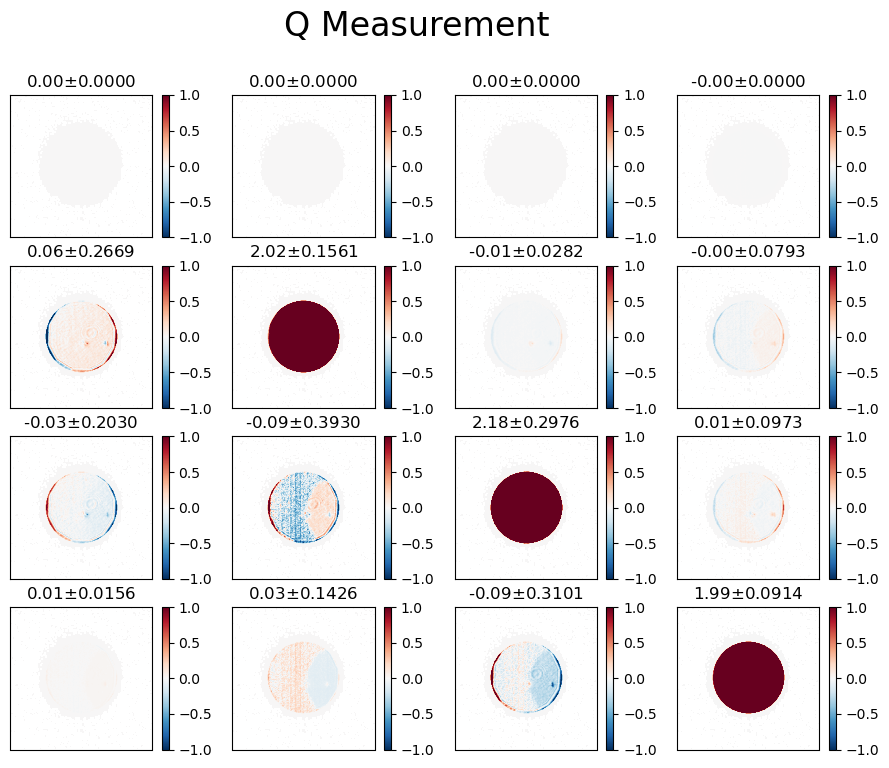

In [105]:
plt.style.use("default")
plot_square(M_measure * mask[..., None, None], vmin=-1, vmax=1, title="Q Measurement")

In [106]:
def q_continuum_from_experiment(experiment, channel="dual"):

    # Where it currently is
    offset = experiment.psa_pol_angle
    starting_angle_psg_pol = experiment.psg_pol_angle - offset
    starting_angle_psg_wvp = np.radians(experiment.psg_starting_angle) - offset
    retardance_psg_wvp = experiment.psg_wvp_ret

    starting_angle_psa_pol = experiment.psa_pol_angle - offset
    starting_angle_psa_wvp = np.radians(experiment.psa_starting_angle) - offset
    retardance_psa_wvp = experiment.psa_wvp_ret

    # Construct the position arrays
    psg_angles = np.radians(np.array(experiment.psg_positions_relative)) + starting_angle_psg_wvp
    psa_angles = np.radians(np.array(experiment.psa_positions_relative)) + starting_angle_psa_wvp


    # Honest to goodness dual_channel
    images = experiment.images
    power_left = []
    power_right = []
    Q = []

    # extract Q next
    for img in images:
        cut_power_left = img[cxl-cut:cxl+cut, cyl-cut:cyl+cut]
        cut_power_right = img[cxr-cut:cxr+cut, cyr-cut:cyr+cut]

        # 3 data points per measurement
        I = cut_power_left + cut_power_right
        power_left.append(cut_power_left / I)
        power_right.append(cut_power_right / I)
        Q.append((cut_power_left - cut_power_right) / I)

    ## SET UP INDIVIDUAL I-Inversions
    # update the psg/psa angles, we will need a boatload of these for independent experiments
    power_left = np.asarray(power_left)
    power_right = np.asarray(power_right)

    shapes = [*power_left.shape[-2:], psa_angles.shape[0]]
    power_left = np.moveaxis(power_left,0,-1)
    power_right = np.moveaxis(power_right,0,-1)

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)

    psa_pol_l = linear_polarizer(starting_angle_psa_pol, shape=shapes)
    psa_pol_r = linear_polarizer(starting_angle_psa_pol + np.pi/2, shape=shapes)

    Mg = psg_wvp @ psg_pol
    Ma_l = psa_pol_l @ psa_wvp
    Ma_r = psa_pol_r @ psa_wvp

    PSA_L = Ma_l[..., 0, :]
    PSA_R = Ma_r[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat_L = broadcast_kron(PSA_L[..., np.newaxis], PSG[..., np.newaxis])
    Wmat_R = broadcast_kron(PSA_R[..., np.newaxis], PSG[..., np.newaxis])
    Wmat_L = Wmat_L.reshape([*Wmat_L.shape[:-2], 16])
    Wmat_R = Wmat_R.reshape([*Wmat_R.shape[:-2], 16])

    # The matrices we want to concatenate pre-inversion
    Winv_L = np.linalg.pinv(Wmat_L)
    Winv_R = np.linalg.pinv(Wmat_R)

    # delete these big matrices to clear up memory
    del Wmat_L, Wmat_R, PSA_L, PSA_R, Ma_l, Ma_r

    ## SET UP Q INVERSION, in the back I guess?
    Q = np.asarray(Q)
    shapes = [*power_left.shape[-2:], psa_angles.shape[0]]
    Q = np.moveaxis(Q,0,-1)

    Ma = psa_wvp

    PSA = Ma[..., 1, :]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat_q = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat_q = Wmat_q.reshape([*Wmat_q.shape[:-2], 16])
    Winv_Q = np.linalg.pinv(Wmat_q)

    # pack it all together
    Q_expand = Q[..., np.newaxis]
    power_left_expand = power_left[..., np.newaxis]
    power_right_expand = power_right[..., np.newaxis]

    Winv = np.concatenate([Winv_L, Winv_R, Winv_Q], axis=-1)
    power_expand = np.concatenate([power_left_expand, power_right_expand, Q_expand], axis=-2)

    # Do the data reduction - BIG MATRIX
    M_meas = Winv @ power_expand
    M_meas = M_meas[..., 0]

    return M_meas.reshape([*M_meas.shape[:-1], 4, 4])

In [107]:
M_measure = q_continuum_from_experiment(air_measure)

C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\3893145015.py:31: RuntimeWarning: invalid value encountered in divide
  power_left.append(cut_power_left / I)
C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\3893145015.py:32: RuntimeWarning: invalid value encountered in divide
  power_right.append(cut_power_right / I)
C:\Users\EPL User\AppData\Local\Temp\ipykernel_4000\3893145015.py:33: RuntimeWarning: invalid value encountered in divide
  Q.append((cut_power_left - cut_power_right) / I)


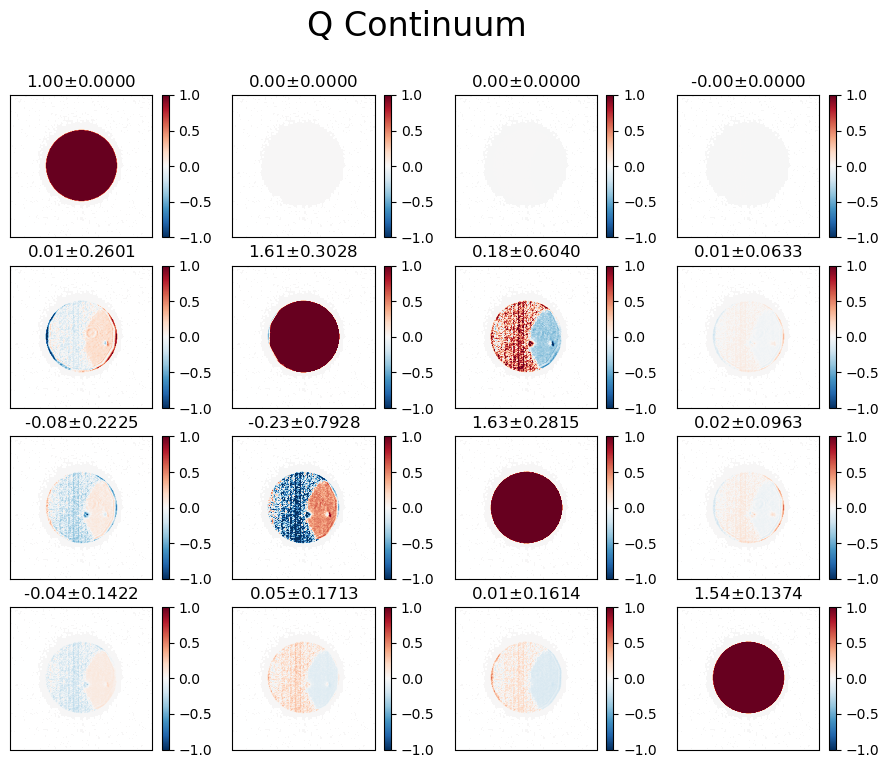

In [108]:
plot_square(M_measure * mask[..., None, None] / M_measure[..., 0, 0, None, None], title="Q Continuum", vmin=-1, vmax=1)

In [41]:
# cam.close()
# fstg.close()
# psg_stg.close()
# psa_stg.close()